# **Multi-Variate Analysis**

### *Dependencies and Imports*

In [ ]:
# Install 5.0.1 altair version
!pip uninstall -y altair
!pip install altair

Found existing installation: altair 5.0.1
Uninstalling altair-5.0.1:
  Successfully uninstalled altair-5.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached altair-5.0.1-py3-none-any.whl (471 kB)


In [ ]:
# Install openpyxl package for reading and writing Excel files (XLSX).
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Used for data manipulation and analysis
import numpy as np
import pandas as pd
from functools import reduce
# Provides functions for displaying interactive rich content in Jupyter notebooks
import ipywidgets as widgets
from IPython.display import display
# Provides functions for interacting with the OS, files, etc.
import requests
import io
import zipfile
import os
# dates and times in Python.
import datetime
# Used for creating visualizations and plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
# statistical functions for  time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Disable the maximum number of rows limit when working with large datasets.
alt.data_transformers.disable_max_rows()
# Enable the default renderer for visualizing Altair plots.
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [ ]:
assert alt.__version__ == '5.0.1', "Altair version 5.0.1 is required."

### *Helper methods*

###### Market Condition Formula
$$
ratio = \frac{{\text{{Current Home Inventory}}}}{{\text{{Amount of Homes Sold in the Last Month}}}}
$$
If ratio $>7$, buyer's market;<br>
If ratio $<5$, seller's market;<br>
If $5<=$ ratio $<=7$, neutral market

In [ ]:

def unpivot_dataframe(file_path, Metric_value='Metric_value'):
    # read csv
    data_frame = pd.read_csv(file_path)

    # Remove unwanted columns
    data_frame = data_frame.drop(['RegionID', 'SizeRank'], axis=1)

    # Unpivot DataFrame from having date values on columns to rows
    data_frame = data_frame.melt(id_vars=['RegionName','RegionType','StateName'], var_name='Date', value_name=Metric_value)

    # Convert Date field to DateTime type
    data_frame['Date'] = pd.to_datetime(data_frame['Date'])

    # Use interpolation to fill missing values.
    # Since the datasets are time series based, By leveraging the temporal information,
    # it can provide a more accurate estimation of values within the desired interval,
    # filling in the missing data between observed data points.
    data_frame = data_frame.set_index('Date')
    data_frame = data_frame.groupby('RegionName', group_keys=False).apply(lambda x: x.interpolate(method='time'))
    data_frame = data_frame.reset_index()

    # drop only entries with NaN values in the metric column
    return data_frame.dropna(subset=[Metric_value])

def plot_timeseries(df, plot_title, y_col='Metric_value'):
    # Filter the DataFrame for the national level data
    nation_df = df[df['RegionType'] == 'country']

    # Create the scatter plot using Plotly Express with the specified title
    fig = px.scatter(nation_df, x="Date", y=y_col, color="RegionName",
                     hover_data=['RegionName', y_col],
                     title=plot_title + " at National level")

    # Display the national level plot
    fig.show()

    # Filter the DataFrame for the metropolitan level data
    metro_df = df[df['RegionType'] != 'country']

    # Create the scatter plot at metropolitan level
    fig = px.scatter(metro_df, x="Date", y=y_col, color="RegionName",
                     hover_data=['RegionName', y_col, 'StateName'],
                     title=plot_title + " at metropolitan level")

    # Display the metropolitan level plot
    fig.show()

    # aggregate timeseries by state
    state_df = metro_df.groupby(['StateName', 'Date']).mean(numeric_only=True).reset_index()

    # Create the scatter plot at metropolitan level
    fig = px.scatter(state_df, x="Date", y=y_col, color="StateName",
                     hover_data=['StateName', y_col],
                     title=plot_title + " at state level")

    # Display the state level plot
    fig.show()

    # Plot trend, seasonality for national level data

    result=seasonal_decompose(nation_df[y_col], model='multiplicative', period=12)
    result.plot()

def calculate_market_types(df):
    ratio = []
    inventory_sales = df[['Date', 'RegionName', 'StateName', 'forSaleInventory', 'salesCountNowcast']]
    for r in inventory_sales['RegionName'].unique():
        tmp = inventory_sales[inventory_sales['RegionName']== r].reset_index(drop=True)
        inventory = tmp['forSaleInventory'][1:].reset_index(drop=True)
        sales_count = tmp['salesCountNowcast'][:-1].reset_index(drop=True)
        ratio.append((tmp['Date'][1:].reset_index(drop=True),
                      tmp['RegionName'][0],
                      tmp['StateName'][0],
                      inventory/sales_count))

    buyer_seller_df = pd.DataFrame(ratio, columns=['Date','RegionName','StateName','Ratio'])
    buyer_seller_df = buyer_seller_df.explode(['Date','Ratio'])
    buyer_seller_df.loc[buyer_seller_df['Ratio'] > 7, 'marketType'] = "Buyer's Market"
    buyer_seller_df.loc[buyer_seller_df['Ratio'] < 5, 'marketType'] = "Seller's Market"
    buyer_seller_df.loc[(buyer_seller_df['Ratio'] >= 5) & (buyer_seller_df['Ratio'] <= 7), 'marketType'] = "Neutral Market"
    buyer_seller_df['Ratio'] = pd.to_numeric(buyer_seller_df['Ratio'])
    return buyer_seller_df

def calculate_market_types_by_states(df):

    buyer_seller_df = calculate_market_types(df)
    buyer_seller_df = buyer_seller_df.groupby(by=["Date", "StateName"]).mean(numeric_only=True).reset_index()

    buyer_seller_df.loc[buyer_seller_df['Ratio'] > 7, 'marketType'] = "Buyer's Market"
    buyer_seller_df.loc[buyer_seller_df['Ratio'] < 5, 'marketType'] = "Seller's Market"
    buyer_seller_df.loc[(buyer_seller_df['Ratio'] >= 5) & (buyer_seller_df['Ratio'] <= 7), 'marketType'] = "Neutral Market"

    return buyer_seller_df

### *Load Datasets*

***Zillow datasets:***

1. *Median List Price*
2. *Median Sale Price*
3. *Home Value Index (ZHVI)*
4. *For-Sale Inventory*
5. *New Listings*
6. *Newly Pending Listings*
7. *mean Days to Pending*
8. *median Days to Pending*
9. *ZORI (Smoothed)*
10. *Sales Count Nowcast*
11. *Share of Listings with a Price Cut*
12. *Median Price Cut*
13. *Percent of Homes Sold Above List*
14. *Percent of Homes Sold Below List*
15. *Median Days to Close*

***FreddieMac Mortgage Rate datasets:***

1. 30yr FRM, 15yr FRM, 5:1 ARM https://www.freddiemac.com/pmms/docs/historicalweeklydata.xlsx

***Immigration datasets:***

1. Persons obtaining lawful permanent resident status by state or territory of residence (Table 4): https://www.dhs.gov/sites/default/files/2022-09/2022_0405_plcy_lawful_permanent_residents_fy2021_excel.zip

In [ ]:
## Provide the root path to this ipynb notebook
root_path = './'

In [ ]:
## For Sale Inventory over the years
file_path = root_path + "/data/for_sale_inventory.csv"
For_Sale_Inventory_df = unpivot_dataframe(file_path, Metric_value='forSaleInventory')

In [ ]:
# Newly Pending Listings over the years
file_path = root_path + "/data/newly_pending_listings.csv"
Newly_Pending_Listings_df = unpivot_dataframe(file_path, Metric_value='newlyPendingListings')

In [ ]:
# Mean Days to Pending over the years
file_path = root_path + "/data/mean_days_to_pending.csv"
Mean_Days_to_Pending_df = unpivot_dataframe(file_path, Metric_value='meanDaystoPending')

In [ ]:
# Median Days to Pending over the years
file_path = root_path + "/data/median_days_to_pending.csv"
Median_Days_to_Pending_df = unpivot_dataframe(file_path, Metric_value='medianDaystoPending')

In [ ]:
# New Listings over the years
file_path = root_path + "/data/new_listings.csv"
New_Listings_df = unpivot_dataframe(file_path, Metric_value='newListings')

In [ ]:
# ZORI Smoothed over the years
file_path = root_path + "/data/zori_smoothed.csv"
ZORI_Smoothed_df = unpivot_dataframe(file_path, Metric_value='rentIndex')

In [ ]:
# Share of listings with a price cut
file_path = root_path + "/data/share_of_listings_with_a_price_cut.csv"
Share_Listings_Pricecut_df = unpivot_dataframe(file_path, Metric_value='shareofListingsWithPricecut')

In [ ]:
# Sales count nowcast
file_path = root_path + "/data/sales_count_nowcast.csv"
Sales_Count_Nowcast_df = unpivot_dataframe(file_path, Metric_value='salesCountNowcast')

In [ ]:
# Percent of homes sold below list
file_path = root_path + "/data/percent_of_homes_sold_below_list.csv"
homes_Sold_Below_List_df = unpivot_dataframe(file_path, Metric_value='percentHomesSoldBelowList')

In [ ]:
# Percent of homes sold above list
file_path = root_path + "/data/percent_of_homes_sold_above_list.csv"
homes_Sold_Above_List_df = unpivot_dataframe(file_path, Metric_value='percentHomesSoldAboveList')

In [ ]:
# Median price cut
file_path = root_path + "/data/median_price_cut.csv"
median_Pricecut_df = unpivot_dataframe(file_path, Metric_value='medianPriceCut')

In [ ]:
# Median days to close
file_path = root_path + "/data/median_days_to_close.csv"
median_Days_To_Close_df = unpivot_dataframe(file_path, Metric_value='medianDaysToClose')

In [ ]:
# Home Value Index (ZHVI)
file_path = root_path + "/data/home_value_index.csv"
home_value_df = unpivot_dataframe(file_path, Metric_value='homeValueIndex')

In [ ]:
# Median List Price
file_path = root_path + "/data/medianListPrice.csv"
median_List_Price_df = unpivot_dataframe(file_path, Metric_value='medianListPrice')

In [ ]:
# Median Sale Price
file_path = root_path + "/data/median_sale_price.csv"
median_sale_price_df = unpivot_dataframe(file_path, Metric_value='medianSalePrice')

In [ ]:
# 30yr FRM, 15yr FRM, 5:1 ARM
mortgage_rate_path = 'https://www.freddiemac.com/pmms/docs/historicalweeklydata.xlsx'
response = requests.get(mortgage_rate_path)

mortgage_file = pd.ExcelFile(io.BytesIO(response.content))
mortgage_df = mortgage_file.parse(mortgage_file.sheet_names[0], skiprows=6, skipfooter=1)
mortgage_df = mortgage_df.rename(columns={'Week': 'week',
                                          'FRM': '30yr',
                                          'points': '30yr_f_p',
                                          'FRM.1': '15yr',
                                          'points.1': '15yr_f_p',
                                          'ARM': '5_1_arm',
                                          'points.2': '5_1_arm_f_p',
                                          'margin': '5_1_arm_margin',
                                          'spread': '30yr_5_1_arm_sprd'})
# get Month & year from weekly data points
mortgage_df['month_year'] = mortgage_df['week'].dt.to_period('M').dt.to_timestamp(how='end').dt.date
mortgage_df['month_year'] = pd.to_datetime(mortgage_df['month_year'])

In [ ]:
# Immigration Data: Table 4
immigration_zip_path = 'https://www.dhs.gov/sites/default/files/2022-09/2022_0405_plcy_lawful_permanent_residents_fy2021_excel.zip'
immigration_file_name = 'fy2021_table4.xlsx'

response = requests.get(immigration_zip_path)
with open('2022_0405_plcy_lawful_permanent_residents_fy2021_excel.zip', 'wb') as zip:
        zip.write(response.content)

with zipfile.ZipFile('2022_0405_plcy_lawful_permanent_residents_fy2021_excel.zip', 'r') as zip_ref:
        zip_ref.extract(immigration_file_name)
immigration_df = pd.read_excel(immigration_file_name, skiprows=3, skipfooter=5)
immigration_df = immigration_df.rename(columns={'State or territory of residence': 'states'})

state_abbreviations = {
    'Total': 'US',
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# Change the 'states' variables to abbreviations in immigration_df
immigration_df['states'] = immigration_df['states'].map(state_abbreviations)
immigration_df = immigration_df.rename(columns={'states': 'StateName'})

### *Consolidate data by joining*

In [ ]:
# Join all Zillow datasets
# dataframes to join
data_frames = [For_Sale_Inventory_df, Newly_Pending_Listings_df, Mean_Days_to_Pending_df,
               Median_Days_to_Pending_df, New_Listings_df, ZORI_Smoothed_df, Share_Listings_Pricecut_df,
               Sales_Count_Nowcast_df, homes_Sold_Below_List_df, homes_Sold_Above_List_df,
               median_Pricecut_df, median_Days_To_Close_df, home_value_df, median_List_Price_df,
               median_sale_price_df]

# Perform Inner Join to avoid NaN values
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['RegionName', 'Date', 'StateName', 'RegionType'], how='inner'), data_frames)

In [ ]:
# Join with Mortgage dataset
# fetch relevant fields and aggregate interest rates by month
mortgage_to_merge_df = mortgage_df[['month_year','30yr', '15yr', '5_1_arm']]
mortgage_to_merge_df = mortgage_to_merge_df.groupby(by=["month_year"]).mean(numeric_only=True).reset_index()
# Perform Inner Join (to drop too old interest rates for which there are no housing metrics) and drop redundant col
df_merged = df_merged.merge(mortgage_to_merge_df, left_on='Date', right_on='month_year', how='inner')
df_merged = df_merged.drop(columns=['month_year'])

### Calculate Correlation matrix


In [ ]:
df_merged.corr(method='spearman', numeric_only=True)

forSaleInventory  newlyPendingListings  \
forSaleInventory                     1.000000              0.785356   
newlyPendingListings                 0.785356              1.000000   
meanDaystoPending                    0.260008             -0.182160   
medianDaystoPending                  0.287391             -0.189140   
newListings                          0.910045              0.885153   
rentIndex                            0.231387              0.365482   
shareofListingsWithPricecut          0.291243              0.098079   
salesCountNowcast                    0.887913              0.865277   
percentHomesSoldBelowList            0.278118             -0.103446   
percentHomesSoldAboveList           -0.294204              0.091696   
medianPriceCut                       0.061722              0.314711   
medianDaysToClose                   -0.038738              0.005761   
homeValueIndex                       0.130899              0.246254   
medianListPrice                      0.194259              0.263821   
medianSalePrice                      0.157167              0.281579   
30yr                                 0.035083             -0.088912   
15yr                                 0.052047             -0.101500   
5_1_arm                              0.147542             -0.103345   

                             meanDaystoPending  medianDaystoPending  \
forSaleInventory                      0.260008             0.287391   
newlyPendingListings                 -0.182160            -0.189140   
meanDaystoPending                     1.000000             0.891910   
medianDaystoPending                   0.891910             1.000000   
newListings                          -0.087525            -0.060301   
rentIndex                            -0.222495            -0.076200   
shareofListingsWithPricecut           0.257686             0.354515   
salesCountNowcast                    -0.081250            -0.049371   
percentHomesSoldBelowList             0.871861             0.738526   
percentHomesSoldAboveList            -0.837822            -0.711145   
medianPriceCut                       -0.469139            -0.350685   
medianDaysToClose                     0.055971            -0.086140   
homeValueIndex                       -0.272913            -0.102942   
medianListPrice                      -0.176631            -0.031691   
medianSalePrice                      -0.284967            -0.121549   
30yr                                  0.177636             0.307194   
15yr                                  0.239495             0.349430   
5_1_arm                               0.315871             0.439009   

                             newListings  rentIndex  \
forSaleInventory                0.910045   0.231387   
newlyPendingListings            0.885153   0.365482   
meanDaystoPending              -0.087525  -0.222495   
medianDaystoPending            -0.060301  -0.076200   
newListings                     1.000000   0.322760   
rentIndex                       0.322760   1.000000   
shareofListingsWithPricecut     0.163234  -0.026688   
salesCountNowcast               0.944073   0.331971   
percentHomesSoldBelowList      -0.038317  -0.232924   
percentHomesSoldAboveList       0.013468   0.257769   
medianPriceCut                  0.256122   0.801926   
medianDaysToClose              -0.056804  -0.149445   
homeValueIndex                  0.242058   0.884433   
medianListPrice                 0.275132   0.858001   
medianSalePrice                 0.271638   0.897878   
30yr                           -0.069213   0.144957   
15yr                           -0.072095   0.114430   
5_1_arm                        -0.012962  -0.016107   

                             shareofListingsWithPricecut  salesCountNowcast  \
forSaleInventory                                0.291243           0.887913   
newlyPendingListings                            0.098079           0.865277   
meanDaystoPending                             

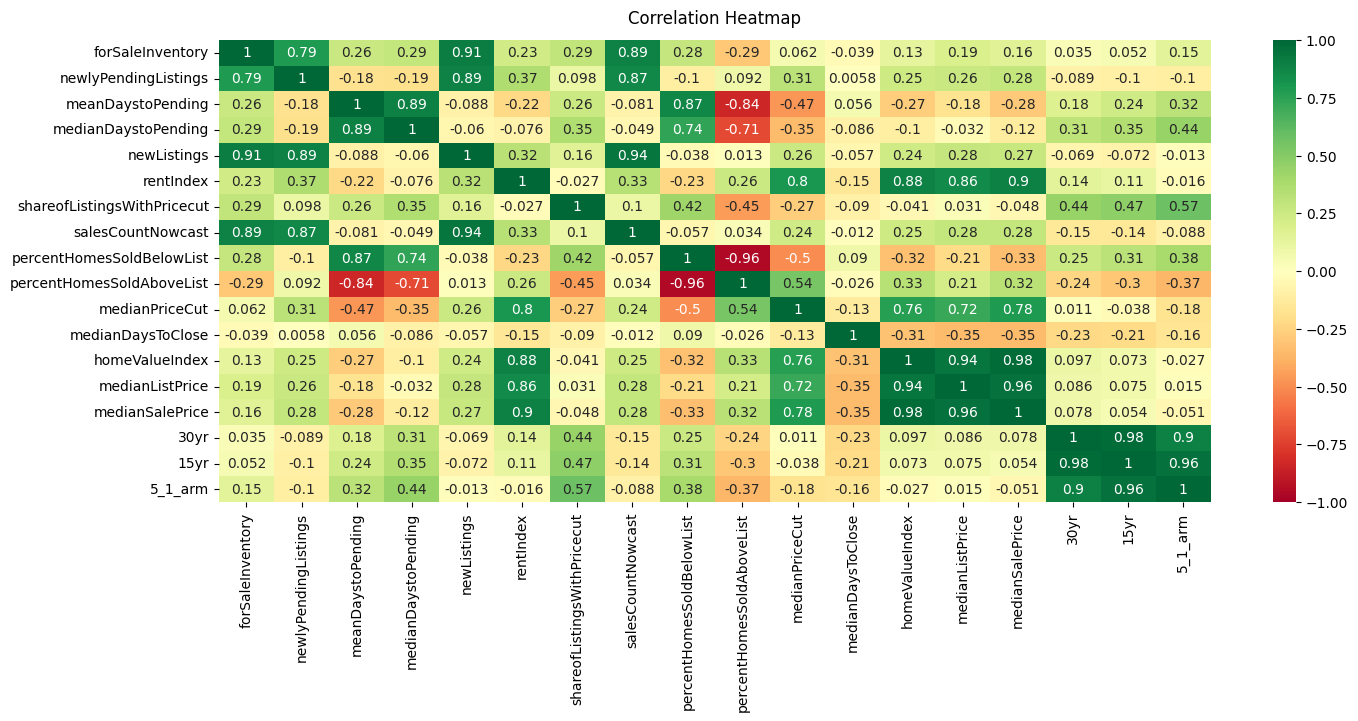

In [ ]:
# re-size of the heatmap.
plt.figure(figsize=(16, 6))
# set correlation values on heatmap from -1 to 1, and display correlation coeff on the heatmap.
heatmap = sns.heatmap(df_merged.corr(method='spearman', numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
# set Heatmap title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### US National Correlation matrix

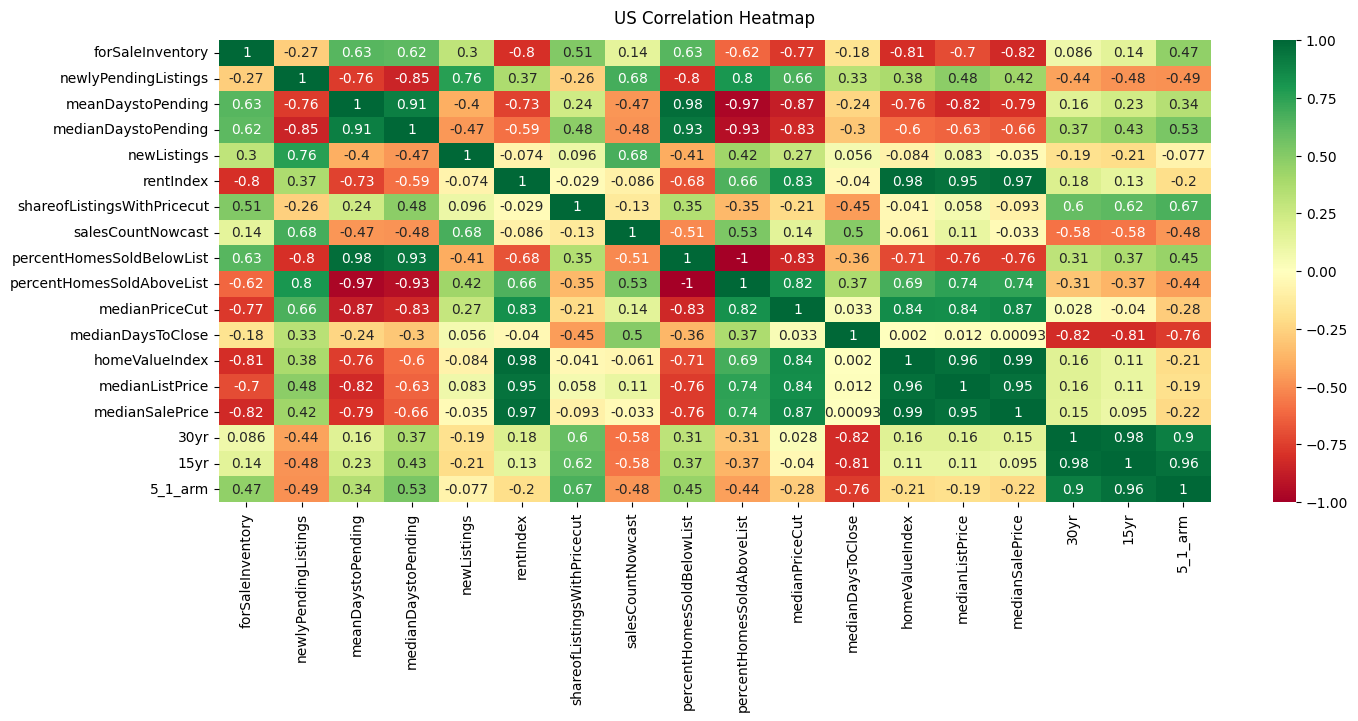

In [ ]:
national_df = df_merged[df_merged['RegionType'] == 'country']

# re-size of the heatmap.
plt.figure(figsize=(16, 6))
# set correlation values on heatmap from -1 to 1, and display correlation coeff on the heatmap.
heatmap = sns.heatmap(national_df.corr(method='spearman', numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
# set Heatmap title
heatmap.set_title('US Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### US State level Correlation matrix (interactive state selection)

Dropdown(description='Calculate Correlation matrix for State:', options=('OH', 'NY', 'NM', 'PA', 'GA', 'TX', '…

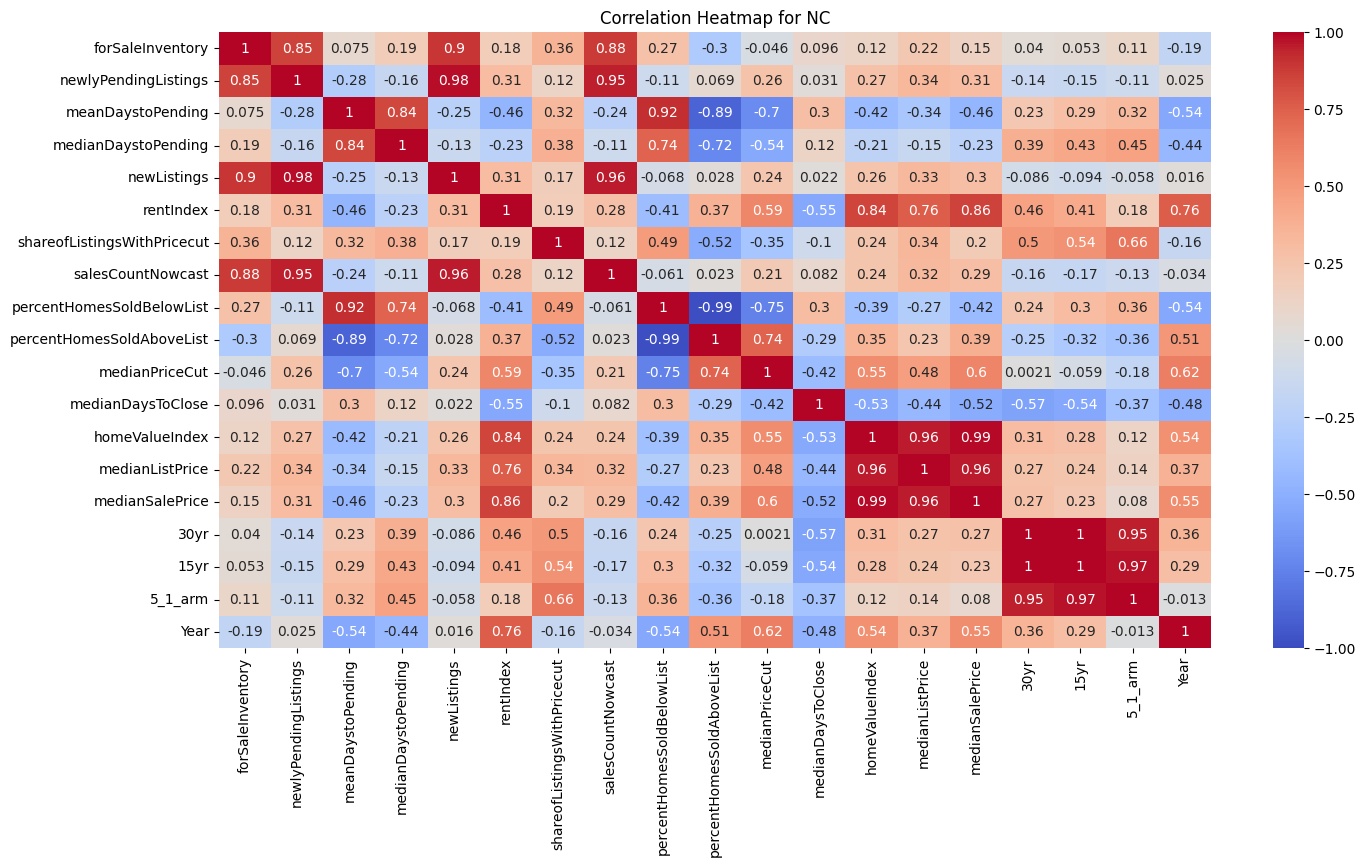

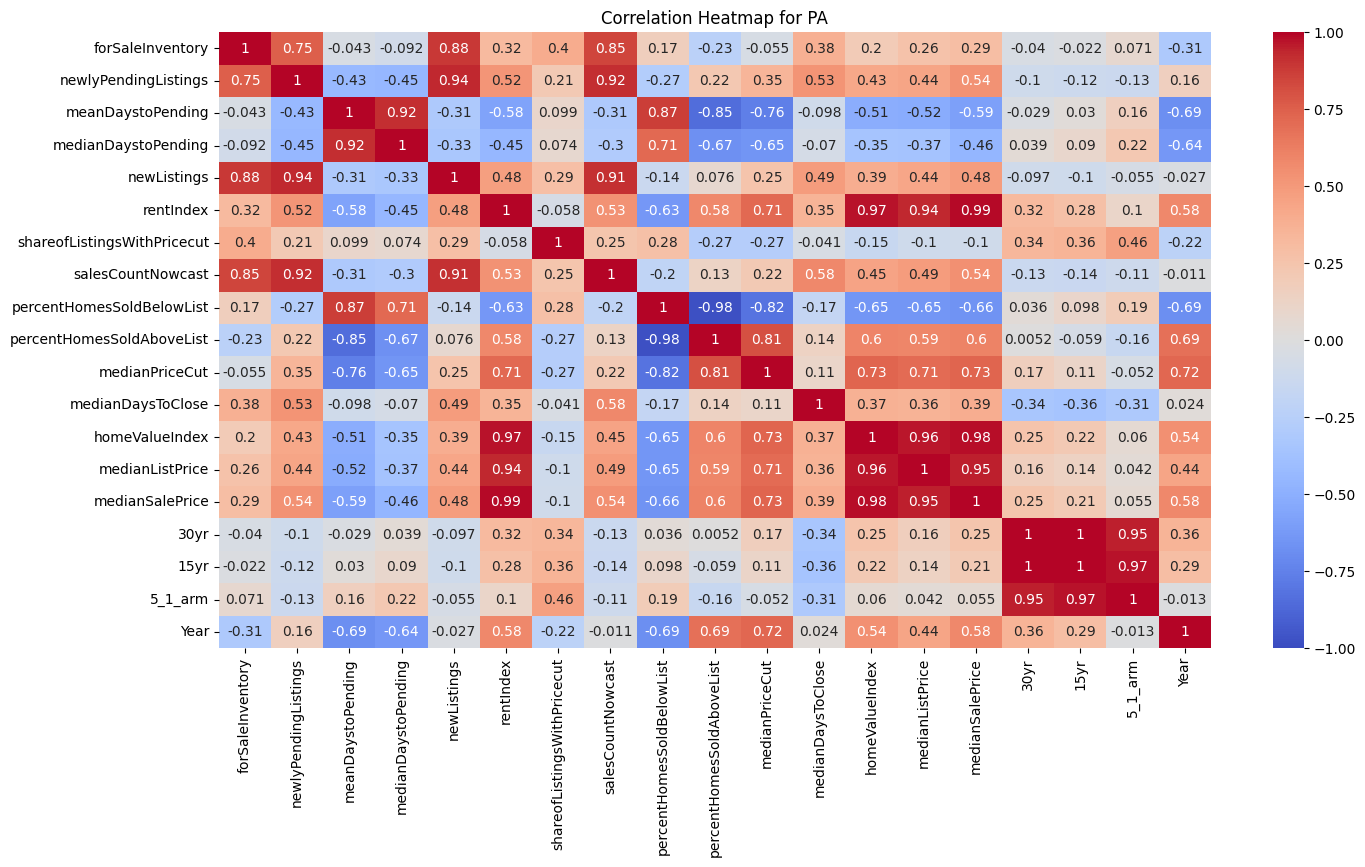

In [ ]:
# Create a dropdown widget for state selection
state_dropdown = widgets.Dropdown(options=df_merged['StateName'].unique(),
                                  description='Calculate Correlation matrix for State:',
                                  style={'description_width': 'initial', 'padding': '10px'})

# Function to handle the state selection event
def on_state_selection(change):
    # get the state name
    selected_state = change.new
    # plot the corr matrix
    generate_correlation_heatmap(df_merged, selected_state)

# Register the event handler for state selection
state_dropdown.observe(on_state_selection, names='value')

# Create a function to generate the correlation heatmap for a given state
def generate_correlation_heatmap(data, state):
    # Filter the data for the selected state
    state_data = data[data['StateName'] == state]

    # heatmap plot
    plt.figure(figsize=(16, 8))
    sns.heatmap(state_data.corr(method='pearson', numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap for {state}")
    plt.show()

# Display the state dropdown widget
display(state_dropdown)

# Note: In Coursera env, the heatmap might appear in Log tab for the ipynb

### Calculate Market Conditions

*https://www.rocketmortgage.com/learn/buyers-market-vs-sellers-market*


In [ ]:
# Calc mortgage rate by state
market_by_states_df = calculate_market_types_by_states(df_merged)

# Get latest market
filter_date = '2023-02-28'
latest_df = market_by_states_df[market_by_states_df['Date'] == filter_date]
fig = px.choropleth(latest_df, locations="StateName",
                    locationmode="USA-states",
                    scope="usa",
                    color="marketType",
                    hover_name="StateName")

fig.update_layout(
    title_text = 'Housing Market condition by State for ' + filter_date,
)

fig.show()

### Market Conditions Across Years

In [ ]:
# Get latest market
alt.Chart(market_by_states_df).mark_bar().encode(
    x='Date:T',
    y='count()',
    color='marketType',
    tooltip=['Date', 'marketType', 'count()']
).properties(
    width=600,
    height=400,
    title='Count of Market Types at State level'
)

alt.Chart(...)

### *Can proxies for buyer's/seller's market be used to predict home prices?*

###### Region agnostic correlation between proxies for buyer's/seller's market vs. home prices (Median Sale Price, Median List Price, Home Value Index)

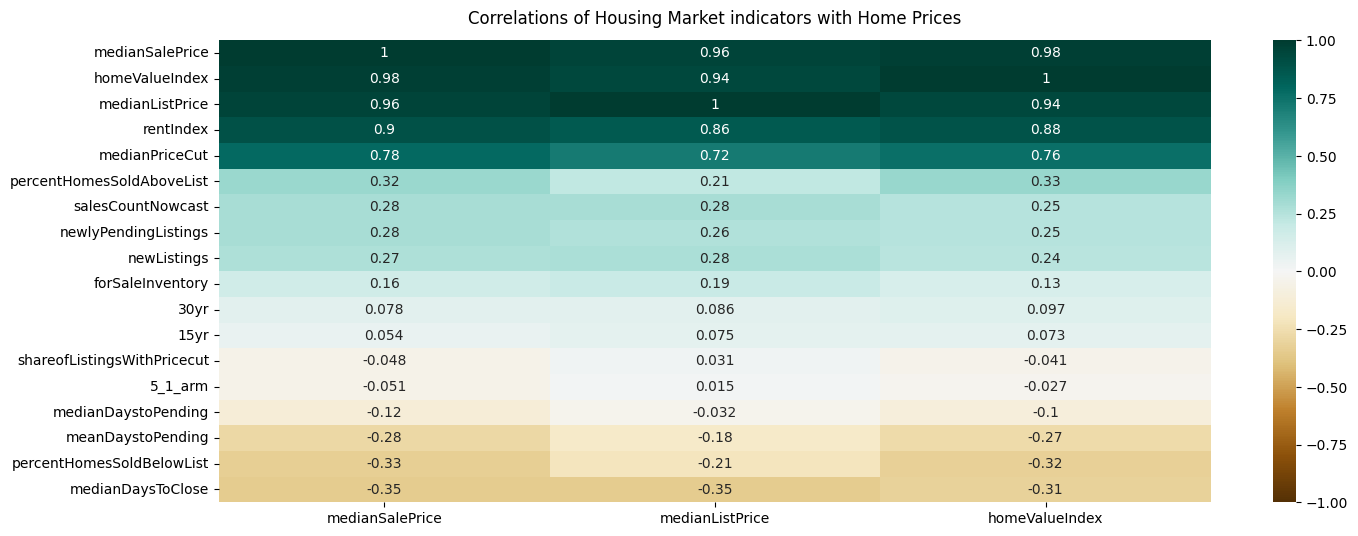

In [ ]:
# re-size of the heatmap.
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df_merged.corr(method='spearman', numeric_only=True)[['medianSalePrice', 'medianListPrice', 'homeValueIndex']].sort_values(by=['medianSalePrice', 'medianListPrice', 'homeValueIndex'], ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlations of Housing Market indicators with Home Prices', fontdict={'fontsize':12}, pad=12);

###### US National level correlation between proxies for buyer's/seller's market vs. home prices (Median Sale Price, Median List Price, Home Value Index)

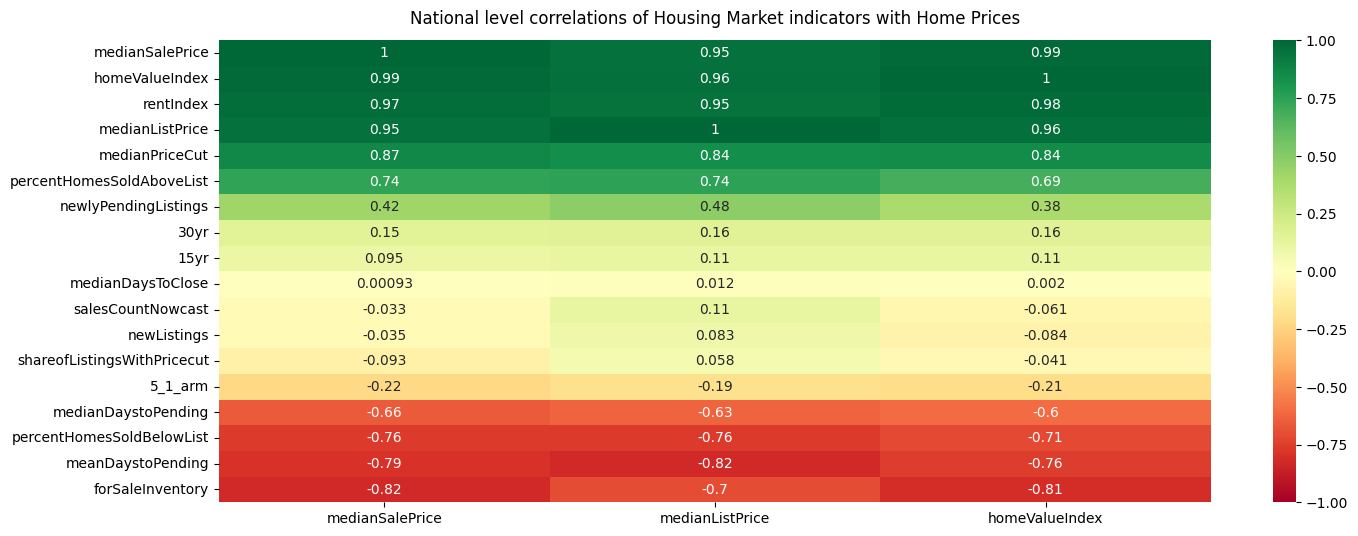

In [ ]:
national_df = df_merged[df_merged['RegionType'] == 'country']

# re-size of the heatmap.
plt.figure(figsize=(16, 6))
# set correlation values on heatmap from -1 to 1, and display correlation coeff on the heatmap.
heatmap = sns.heatmap(national_df.corr(method='spearman', numeric_only=True)[['medianSalePrice', 'medianListPrice', 'homeValueIndex']].sort_values(by=['medianSalePrice', 'medianListPrice', 'homeValueIndex'], ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
# set Heatmap title
heatmap.set_title('National level correlations of Housing Market indicators with Home Prices', fontdict={'fontsize':12}, pad=12);

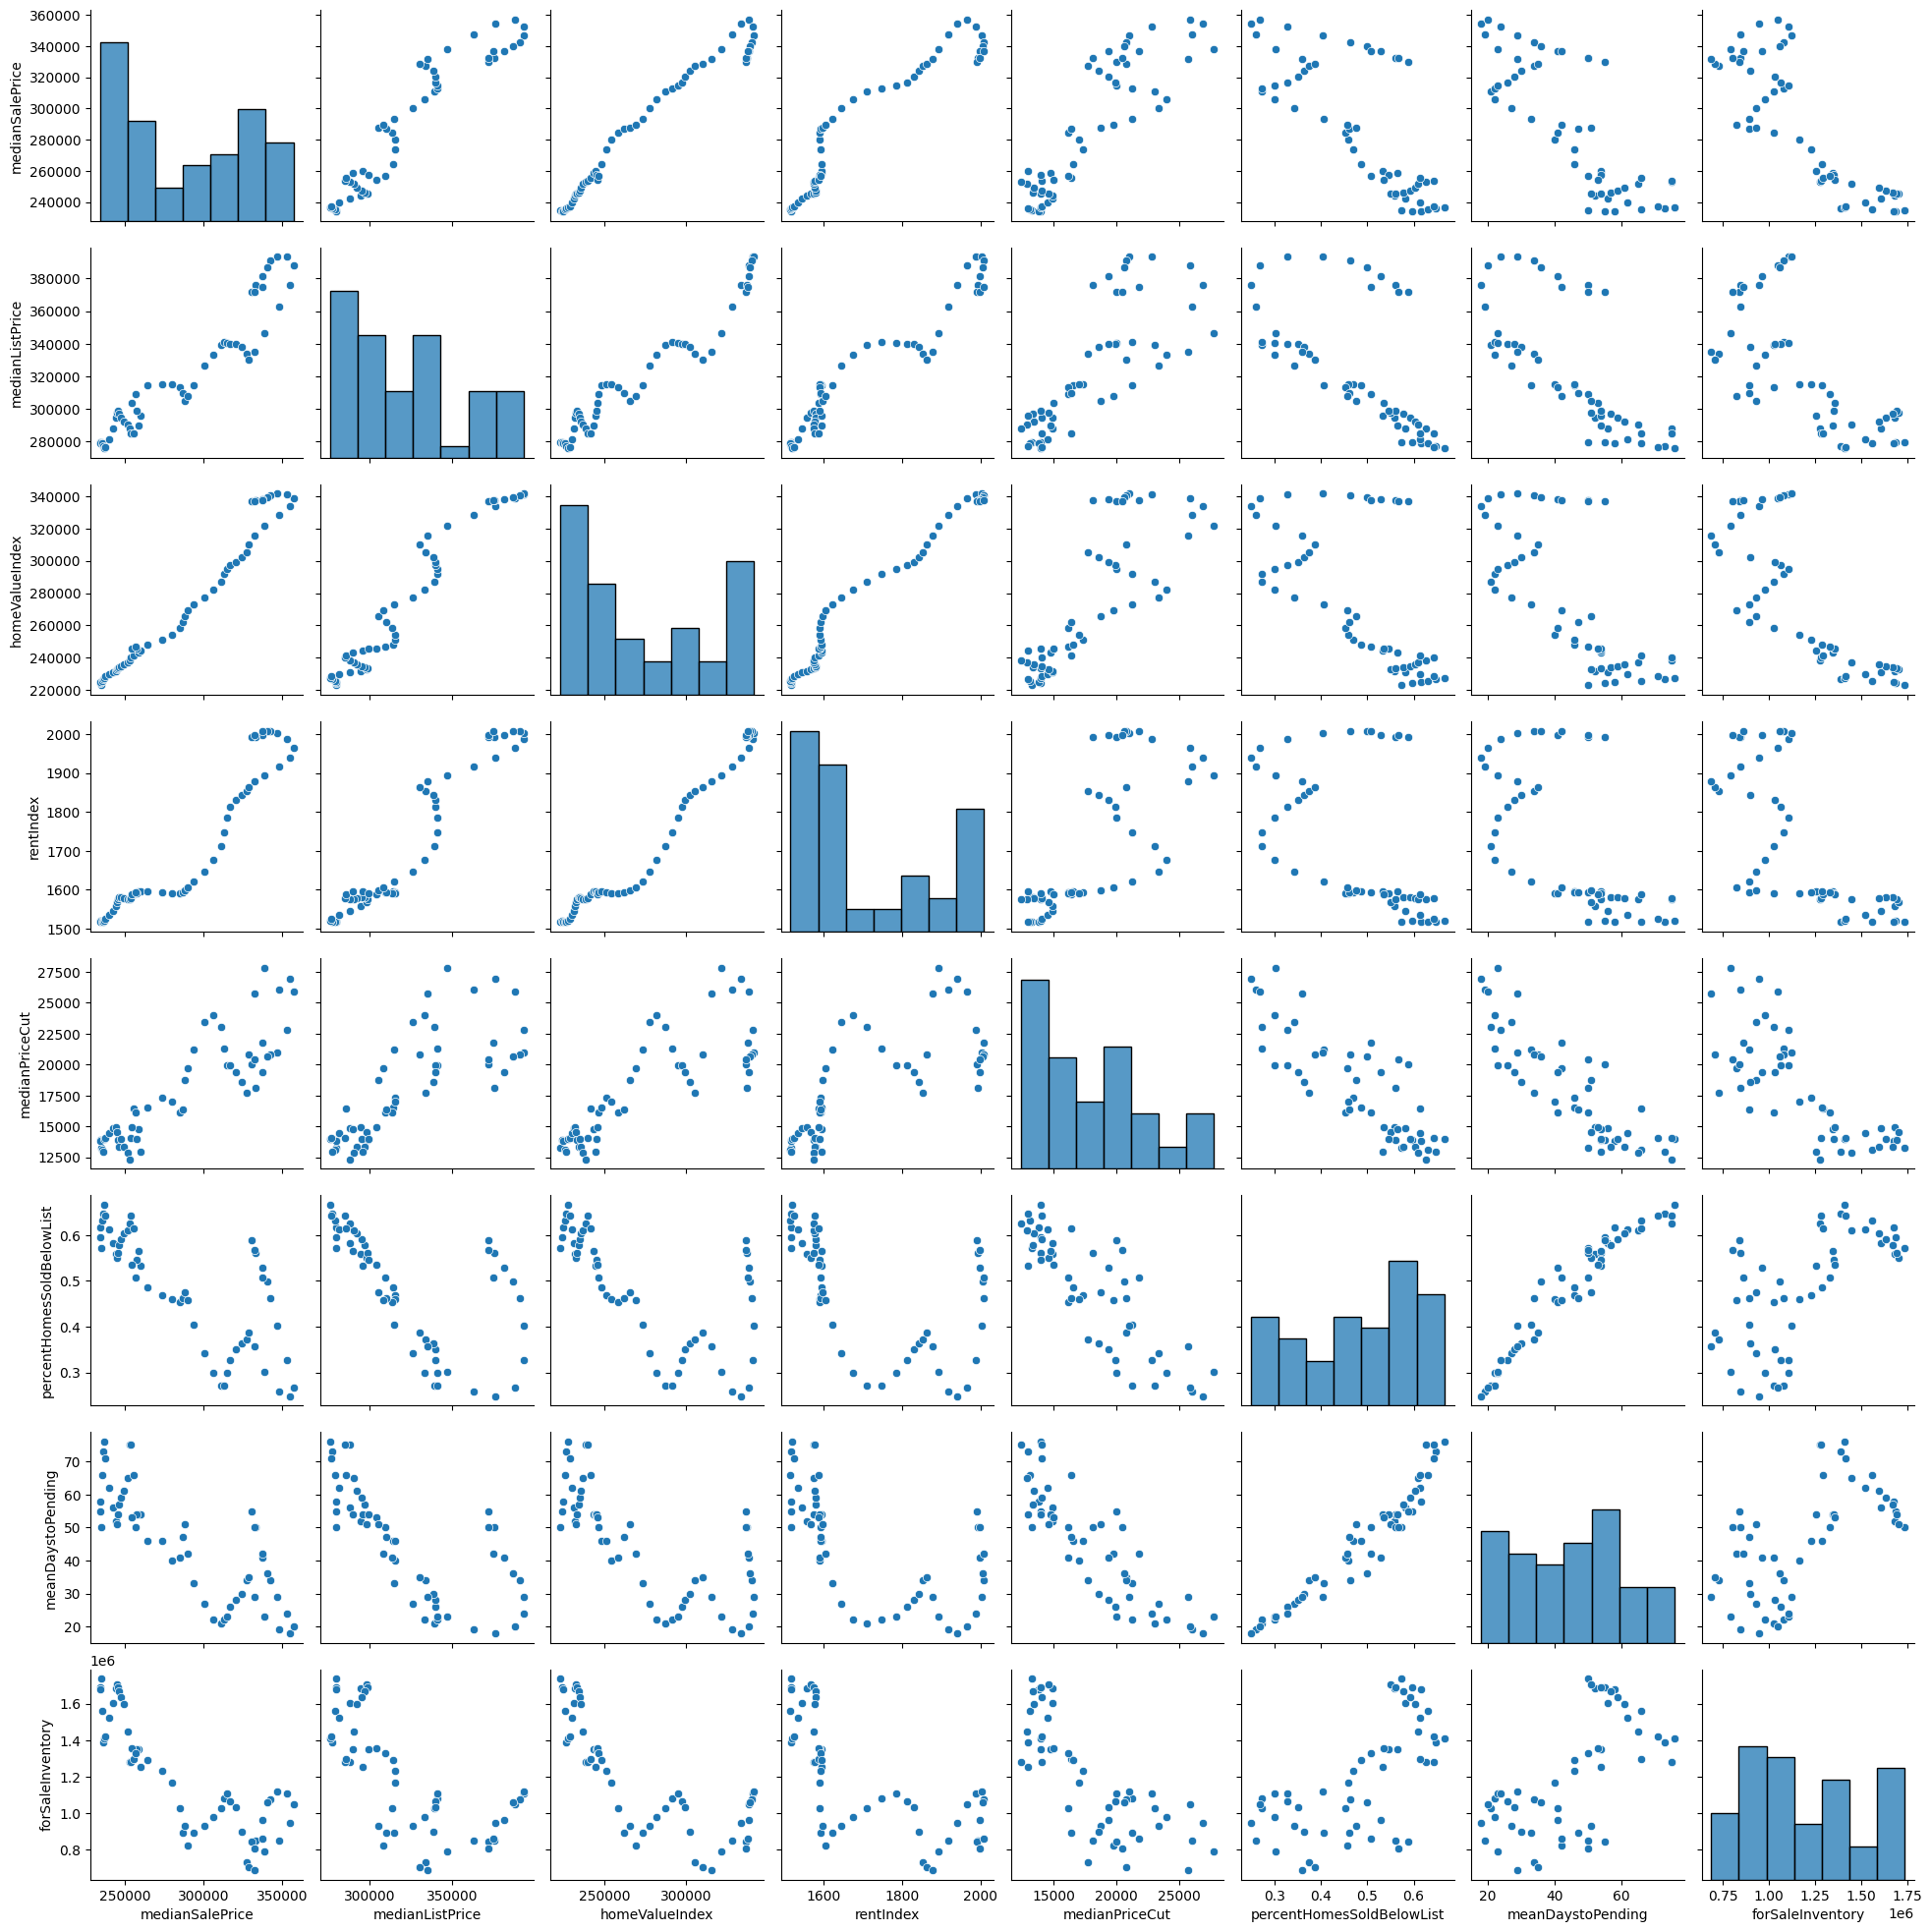

In [ ]:
# SPLOM of different indicators
sns.pairplot(national_df, diag_kind='hist', vars=['medianSalePrice', 'medianListPrice', 'homeValueIndex',
                                                  'rentIndex', 'medianPriceCut', 'percentHomesSoldBelowList',
                                                  'meanDaystoPending', 'forSaleInventory']);

##### ***Analysis:***

The correlation analysis using the Spearman coefficient reveals several relationships between home price metrics and other variables.

Positive correlations were observed with following:
1. Rental prices (SmoothedZORI). Higher rental prices tend to be associated with higher home prices.
2. Price cuts (MedianPriceCut). Larger price cuts are associated with higher home prices.
3. Percentage of homes sold above the list price (PercentHomesSoldAboveList). A higher proportion of homes selling above the list price is associated with higher home prices.

Conversely, negative correlations were found with following:
1. Percent of Homes Sold Below List (percentHomesSoldBelowList). A higher proportion of homes selling below the list price is associated with lower home prices.
2. Days to Pending (mean/medianDaystoPending). Longer time on the market is associated with lower home prices.
3. For Sale Inventory (forSaleInventory).  It suggests that a higher supply of homes on the market may be associated with lower home prices.



###### US choropleth of Latest home prices (Median Sale Price, Median List Price, Home Value Index)

In [ ]:
# Get latest housing data
filter_date = '2023-02-28'
latest_df = df_merged[df_merged['Date'] == filter_date]

# agg data by state
latest_df = latest_df.groupby(by=["StateName"]).mean(numeric_only=True).reset_index()

# choropleth of Latest Median Sales price by State
fig = px.choropleth(latest_df, locations="StateName",
                    locationmode="USA-states",
                    scope="usa",
                    color="medianSalePrice",
                    hover_name="StateName")

fig.update_layout(
    title_text = 'Latest Median Sales price by State for ' + filter_date,
)

fig.show()

In [ ]:
# choropleth of Latest Median List price by State
fig = px.choropleth(latest_df, locations="StateName",
                    locationmode="USA-states",
                    scope="usa",
                    color="medianListPrice",
                    hover_name="StateName")

fig.update_layout(
    title_text = 'Latest Median List price by State for ' + filter_date,
)

fig.show()

In [ ]:
# choropleth of Latest Home Value Index by State
fig = px.choropleth(latest_df, locations="StateName",
                    locationmode="USA-states",
                    scope="usa",
                    color="homeValueIndex",
                    hover_name="StateName")

fig.update_layout(
    title_text = 'Latest Home Value Index by State for ' + filter_date,
)

fig.show()

### *Are there specific mortgage rates thresholds or trends that indicate a shift towards a buyer's or seller's market?*

In [ ]:
# Create a trace for each line
trace_30yr = go.Scatter(x=mortgage_df['month_year'], y=mortgage_df['30yr'], name='30yr')
trace_15yr = go.Scatter(x=mortgage_df['month_year'], y=mortgage_df['15yr'], name='15yr')
trace_5_1_arm = go.Scatter(x=mortgage_df['month_year'], y=mortgage_df['5_1_arm'], name='5:1 ARM')

# Create the data list with all traces
data = [trace_30yr, trace_15yr, trace_5_1_arm]

# Define the layout
layout = go.Layout(
    title='Mortgage Interest Rates Over Time',
    xaxis=dict(title='month_year'),
    yaxis=dict(title='Interest Rate')
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Display the figure
fig.show()


In [ ]:
# Determine Market conditions for every Metropolitan statistical area

market_type_df = calculate_market_types(df_merged)

# Filter for mortgage data since 2018
mortgage_2018_df = mortgage_df[mortgage_df['week'].dt.year >= 2018]

# Group the data by date and market type and calculate the count
grouped_df = market_type_df.groupby(['Date', 'marketType']).size().reset_index(name='count')

# Create the stacked bar chart of market types
bar_chart = alt.Chart(grouped_df).mark_bar().encode(
    x='Date:T',
    y=alt.Y('count:Q', title='Count per Market Type'),
    color=alt.Color('marketType:N', title='Market Type'),
    tooltip=['Date', 'marketType', 'count']
).properties(
    width=700,
    height=500,
    title='Count of Market Types (at Metro level) vs. Mortgage Rates'
)

# Create the line chart for mortgage data
line_chart = alt.Chart(mortgage_2018_df).transform_fold(
    ['30yr', '15yr', '5_1_arm'],
    as_=['variable', 'value']
).mark_line().encode(
    x=alt.X('week:T', title='Date'),
    y=alt.Y('value:Q', title='Interest Rate'),
    color=alt.Color('variable:N', title='Interest Rate'),
    tooltip=['30yr', '15yr', '5_1_arm', 'week']
).properties(
    width=700,
    height=500
)

# Combine the charts
combined_chart = alt.layer(bar_chart, line_chart).resolve_scale(
    y='independent'
)

# Show the combined chart
combined_chart


alt.LayerChart(...)

##### ***Analysis:***

On August 26, 2021, mortgage rates reached their lowest levels:

- 30-year Fixed-Rate Mortgage (FRM) was at 2.87%.
- 15-year FRM was at 2.17%.
- 5/1 Adjustable Rate Mortgage (ARM) was at 2.42%.

Additionally, during the month of August 2021, out of the 94 Metropolitan statistical areas analyzed, all of them were categorized as seller's markets, with no regions classified as buyer's markets or neutral markets.

***There is a loosely inverse relationship between mortgage rates and the prevalence of seller's markets.***

### *Which indicators in Zillow's housing data are most useful for determining whether the current market favors buyers or sellers?*

In [ ]:
buyer_seller_df = calculate_market_types(df_merged)

In [ ]:
# Market type Ratio for NYC is less than 5, indicating seller's market
buyer_seller_df[(buyer_seller_df['RegionName']=='New York, NY') & (buyer_seller_df['Date']=='2021-08-31')]

Date    RegionName StateName     Ratio       marketType
50 2021-08-31  New York, NY        NY  3.317296  Seller's Market

##### Market Condition Formula
$$
ratio = \frac{{\text{{Current Home Inventory}}}}{{\text{{Amount of Homes Sold in the Last Month}}}}
$$
If ratio $>7$, buyer's market;<br>
If ratio $<5$, seller's market;<br>
If $5<=$ ratio $<=7$, neutural market

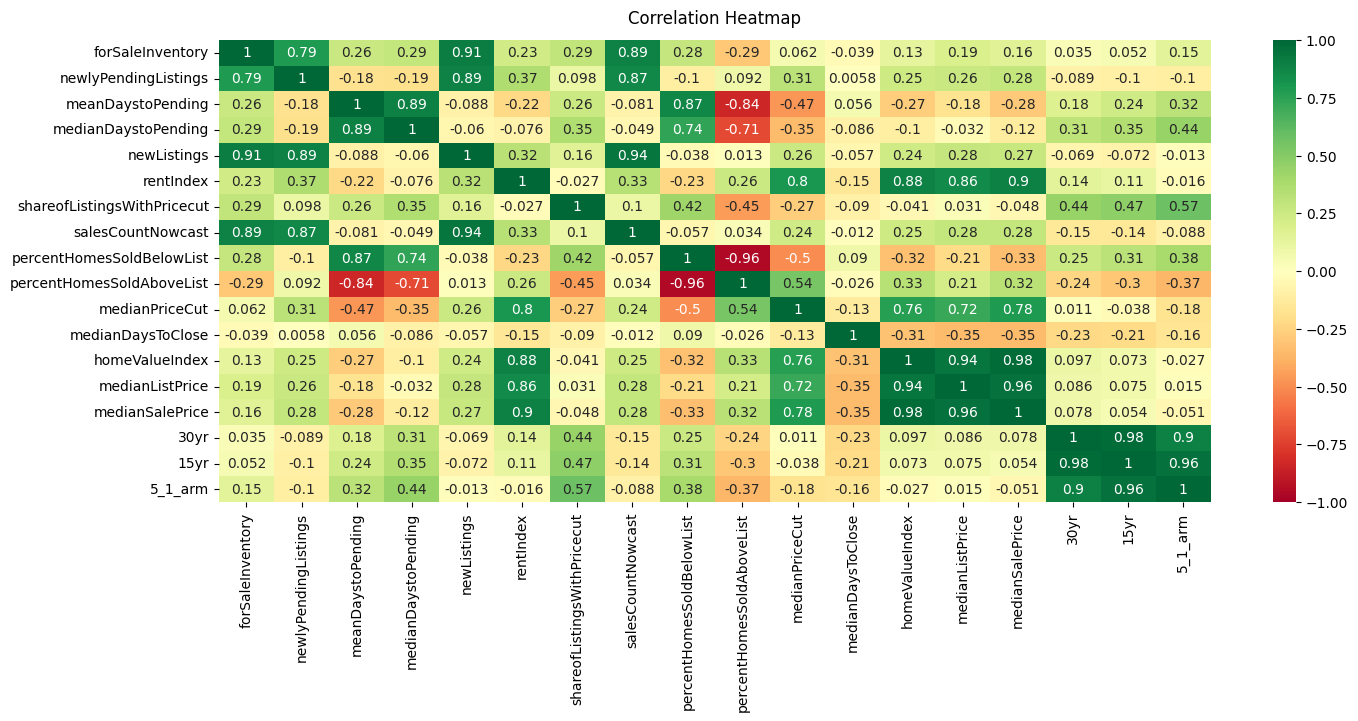

In [ ]:
# re-size of the heatmap.
plt.figure(figsize=(16, 6))
# set correlation values on heatmap from -1 to 1, and display correlation coeff on the heatmap.
heatmap = sns.heatmap(df_merged.corr(method='spearman', numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
# set Heatmap title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
alt.Chart(buyer_seller_df).mark_line().encode(
    x = alt.X('Date:T', title='Date'),
    y = alt.Y('Ratio:Q', title='Market Type Ratio'),
    color = alt.Color('RegionName:N', legend=None),
    tooltip=['RegionName', 'Ratio']
).properties(
    width=800,
    height=300,
    title="Buyer/Seller Market per metro region"
)

alt.Chart(...)

Overall, the property market predominantly favors sellers in the majority of areas. However, there are a few notable spikes that favor buyers, each of which has a relatively short duration. From July 2021 to the end of 2022, it can be characterized as a seller's market. However, there was a brief period of a buyer's market in early 2023. The chart below provides the trend for each region.

In [ ]:
regions = list(buyer_seller_df['RegionName'].unique())
regions.sort()
dropdown_selection = alt.selection_point(
    name='Select',
    fields=['RegionName'],
    value='Akron, OH',
    bind=alt.binding_select(options=regions)
)
interval_selection = alt.selection_interval(bind='scales', encodings=['y'])

opacityCondition = alt.condition(dropdown_selection, alt.value(0.75), alt.value(0.0))
colorCondition = alt.condition(dropdown_selection, alt.Color('RegionName:N', legend=None), alt.value('white'))

base = alt.Chart(buyer_seller_df).mark_line().add_params(
    dropdown_selection,
    interval_selection
).encode(
    x = alt.X('Date:T', title=None),
    y = alt.Y('Ratio:Q', title='Market Type Ratio', scale=alt.Scale(domain=[-1, 13])),
    color = colorCondition,
    opacity = opacityCondition
)
cutoff = pd.DataFrame({
    'start': [-1, 5, 7],
    'stop': [5, 7, 13],
    'index': ['Seller', 'Neutural', 'Buyer']
})

areas = alt.Chart(
    cutoff.reset_index()
).mark_rect(
    opacity=0.2
).encode(
    y=alt.Y('start', title=''),
    y2='stop',
    x=alt.value(0),  # pixels from left
    x2=alt.value(1000),
    color=alt.Color('index:N', legend=alt.Legend(title='Market Type'))
)

# Combine the chart layers
chart = alt.layer(base, areas).resolve_scale(shape='independent', color='independent'
).properties(
    width=800,
    height=300,
    title="Buyer/Seller Market"
)
chart

alt.LayerChart(...)

##### ***Analysis:***

**Indicators for determining whether the current market favors buyers or sellers:**

*   forSaleInventory
*   newlyPendingListings
*   newListings
*   saleCountNowcast

The market condition can be assessed based on the ratio of current home inventory to the number of homes sold in the previous month. Various factors, such as new listings, newly pending listings, sales count nowcast, and sale inventory, exhibit a strong correlation with each other based on the correlation heatmap. These data can serve as valuable indicators for predicting whether the current market is favorable for sellers or buyers.

### *Is it worth competing with multiple offers when purchasing a property for rental purposes?*

##### Price-to-Rent Ratio Formula
$$
ratio = \frac{{\text{{Median Home Price​​}}}}{{\text{{Median Annual Rent​​}}}}
$$

If $1<=$ ratio $<=15$, better to **buy**<br>
If $16<=$ ratio $<=20$, better to **rent**<br>
If ratio $>=21$, much better to **rent**<br>

In [ ]:
# merge median List Price and rent index datasets
data_frames = [median_List_Price_df, ZORI_Smoothed_df]

# Join all dataframes
rent_buy = reduce(lambda  left,right: pd.merge(left,right,on=['RegionName', 'Date', 'StateName', 'RegionType'], how='inner'), data_frames)

rent_buy.tail()

Date      RegionName RegionType StateName  medianListPrice  \
21211 2023-04-30        York, PA        msa        PA         258266.0   
21212 2023-04-30  Youngstown, OH        msa        OH         151633.0   
21213 2023-04-30   Yuba City, CA        msa        CA         457967.0   
21214 2023-04-30        Yuma, AZ        msa        AZ         296167.0   
21215 2023-04-30  Zanesville, OH        msa        OH         184383.0   

         rentIndex  
21211  1324.382637  
21212   892.772894  
21213  2075.166667  
21214  1480.208333  
21215   936.250000

In [ ]:
rent_buy['pricerentRatio'] = rent_buy['medianListPrice']/(rent_buy['rentIndex']*12)
rent_buy.tail()

Date      RegionName RegionType StateName  medianListPrice  \
21211 2023-04-30        York, PA        msa        PA         258266.0   
21212 2023-04-30  Youngstown, OH        msa        OH         151633.0   
21213 2023-04-30   Yuba City, CA        msa        CA         457967.0   
21214 2023-04-30        Yuma, AZ        msa        AZ         296167.0   
21215 2023-04-30  Zanesville, OH        msa        OH         184383.0   

         rentIndex  pricerentRatio  
21211  1324.382637       16.250716  
21212   892.772894       14.153749  
21213  2075.166667       18.390772  
21214  1480.208333       16.673723  
21215   936.250000       16.411482

In [ ]:
alt.Chart(rent_buy).mark_line().encode(
    x = alt.X('Date:T', title='Time'),
    y = alt.Y('pricerentRatio:Q', title='Price-Rent Ratio'),
    color = alt.Color('RegionName:N', legend=None),
    tooltip=['RegionName', 'pricerentRatio']
).properties(
    width=800,
    height=300,
    title="Static Rent/Buy"
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
regions = list(rent_buy['RegionName'].unique())
regions.sort()
dropdown_selection = alt.selection_point(
    name='Select',
    fields=['RegionName'],
    value='Akron, OH',
    bind=alt.binding_select(options=regions)
)
interval_selection = alt.selection_interval(bind='scales', encodings=['y'])

opacityCondition = alt.condition(dropdown_selection, alt.value(0.75), alt.value(0.0))
colorCondition = alt.condition(dropdown_selection, alt.Color('RegionName:N', legend=None), alt.value('black'))

base = alt.Chart(rent_buy).mark_line().add_params(
    dropdown_selection,
    interval_selection
).encode(
    x = alt.X('Date:T', title=None),
    y = alt.Y('pricerentRatio:Q', title='Price to Rent Ratio', scale=alt.Scale(domain=[0, 60])),
    color = colorCondition,
    opacity = opacityCondition
)
cutoff = pd.DataFrame({
    'start': [1, 15, 20],
    'stop': [15, 20, 60],
    'index': ['Better to Buy', 'Better to Rent', 'Much Better to Rent']
})

areas = alt.Chart(
    cutoff.reset_index()
).mark_rect(
    opacity=0.2
).encode(
    y=alt.Y('start', title=''),
    y2='stop',
    x=alt.value(0),  # pixels from left
    x2=alt.value(1000),
    color=alt.Color('index:N', legend=alt.Legend(title=''))
)

# Combine the chart layers
chart = alt.layer(base, areas).resolve_scale(shape='independent', color='independent'
).properties(
    width=800,
    height=300,
    title="Buy or Rent"
)
chart

Output hidden; open in https://colab.research.google.com to view.

##### ***Analysis:***

In a thriving rental market, there are instances where it may be beneficial to engage in a competitive bidding process when making an investment purchase. A higher rental demand can lead to a reduction in the price-to-rent ratio, thereby increasing potential profits. However, it is crucial to note that the rent index demonstrates a strong correlation with both list price, sale price, and home value index. Consequently, if the price-to-rent ratio becomes excessively high, it may not be advisable to participate in a competitive bidding scenario.

### *How might immigration impact the real estate market?*

In [ ]:
df_merged['Year'] = df_merged['Date'].dt.year
df_yearly = df_merged.groupby(['Year','StateName']).mean(numeric_only=True).reset_index()
df_yearly.head()

Year StateName  forSaleInventory  newlyPendingListings  meanDaystoPending  \
0  2018        AL       6052.200000                785.20          55.800000   
1  2018        AR       4985.600000                 64.80          83.400000   
2  2018        AZ      14960.700000               1793.50          47.800000   
3  2018        CA       9030.300000               1754.52          45.880000   
4  2018        CO       5653.533333               1311.00          43.266667   

   medianDaystoPending  newListings    rentIndex  shareofListingsWithPricecut  \
0                27.60  1260.600000  1082.467257                     0.164743   
1                65.20   901.600000   915.996075                     0.169341   
2                24.70  4208.800000  1151.087265                     0.228321   
3                27.96  2549.780000  2038.486578                     0.232529   
4                25.00  1808.866667  1461.077070                     0.231779   

   salesCountNowcast  percentHomesSoldBelowList  percentHomesSoldAboveList  \
0            1461.20                   0.626025                   0.162531   
1             866.40                   0.712855                   0.100030   
2            4024.50                   0.575347                   0.178012   
3            2527.78                   0.506991                   0.347589   
4            2025.60                   0.498633                   0.244070   

   medianPriceCut  medianDaysToClose  homeValueIndex  medianListPrice  \
0    10447.018686          39.200000   156857.636209    220481.600000   
1     7384.921733          30.400000   143204.945048    185720.000000   
2     8622.377178          31.300000   241993.070565    286793.300000   
3    25385.157218          33.040000   563459.439961    583389.400000   
4    11235.229820          36.266667   389787.930823    401264.533333   

   medianSalePrice    30yr    15yr  5_1_arm  
0    189216.000000  4.7022  4.1435    4.004  
1    159432.000000  4.7022  4.1435    4.004  
2    234342.500000  4.7022  4.1435    4.004  
3    533447.140000  4.7022  4.1435    4.004  
4    354133.066667  4.7022  4.1435    4.004

In [ ]:
# Melt to unpivot immigration_df to merge easier with df_yearly
immigration_df_melt = immigration_df.melt(id_vars='StateName', var_name='Year', value_name='Immigrants')

# Merge df_yearly and immigration_df_melt by StateName and Year
merged_Immigrant_df = pd.merge(df_yearly, immigration_df_melt, on=['StateName', 'Year'], how='inner')
merged_Immigrant_df.head()

Year StateName  forSaleInventory  newlyPendingListings  meanDaystoPending  \
0  2018        AL       6052.200000                785.20          55.800000   
1  2018        AR       4985.600000                 64.80          83.400000   
2  2018        AZ      14960.700000               1793.50          47.800000   
3  2018        CA       9030.300000               1754.52          45.880000   
4  2018        CO       5653.533333               1311.00          43.266667   

   medianDaystoPending  newListings    rentIndex  shareofListingsWithPricecut  \
0                27.60  1260.600000  1082.467257                     0.164743   
1                65.20   901.600000   915.996075                     0.169341   
2                24.70  4208.800000  1151.087265                     0.228321   
3                27.96  2549.780000  2038.486578                     0.232529   
4                25.00  1808.866667  1461.077070                     0.231779   

   salesCountNowcast  ...  percentHomesSoldAboveList  medianPriceCut  \
0            1461.20  ...                   0.162531    10447.018686   
1             866.40  ...                   0.100030     7384.921733   
2            4024.50  ...                   0.178012     8622.377178   
3            2527.78  ...                   0.347589    25385.157218   
4            2025.60  ...                   0.244070    11235.229820   

   medianDaysToClose  homeValueIndex  medianListPrice  medianSalePrice  \
0          39.200000   156857.636209    220481.600000    189216.000000   
1          30.400000   143204.945048    185720.000000    159432.000000   
2          31.300000   241993.070565    286793.300000    234342.500000   
3          33.040000   563459.439961    583389.400000    533447.140000   
4          36.266667   389787.930823    401264.533333    354133.066667   

     30yr    15yr  5_1_arm  Immigrants  
0  4.7022  4.1435    4.004        3737  
1  4.7022  4.1435    4.004        3000  
2  4.7022  4.1435    4.004       18335  
3  4.7022  4.1435    4.004      200897  
4  4.7022  4.1435    4.004       13913  

[5 rows x 21 columns]

In [ ]:
merged_Immigrant_df.corr(method='spearman', numeric_only=True)

forSaleInventory  newlyPendingListings  \
forSaleInventory                     1.000000              0.749245   
newlyPendingListings                 0.749245              1.000000   
meanDaystoPending                    0.280533             -0.285156   
medianDaystoPending                  0.316106             -0.281976   
newListings                          0.875368              0.921198   
rentIndex                            0.352592              0.540235   
shareofListingsWithPricecut          0.345651              0.008767   
salesCountNowcast                    0.859104              0.917342   
percentHomesSoldBelowList            0.275332             -0.233293   
percentHomesSoldAboveList           -0.214746              0.251640   
medianPriceCut                       0.082757              0.380120   
medianDaysToClose                    0.050384              0.019377   
homeValueIndex                       0.152343              0.359563   
medianListPrice                      0.163074              0.320868   
medianSalePrice                      0.138353              0.391912   
30yr                                 0.288893             -0.230364   
15yr                                 0.298681             -0.221327   
5_1_arm                              0.294902             -0.227370   
Immigrants                           0.745898              0.647804   

                             meanDaystoPending  medianDaystoPending  \
forSaleInventory                      0.280533             0.316106   
newlyPendingListings                 -0.285156            -0.281976   
meanDaystoPending                     1.000000             0.945777   
medianDaystoPending                   0.945777             1.000000   
newListings                          -0.151721            -0.112519   
rentIndex                            -0.260898            -0.222548   
shareofListingsWithPricecut           0.507283             0.564326   
salesCountNowcast                    -0.179091            -0.135480   
percentHomesSoldBelowList             0.859115             0.800573   
percentHomesSoldAboveList            -0.806053            -0.742865   
medianPriceCut                       -0.486784            -0.450533   
medianDaysToClose                     0.100811            -0.013750   
homeValueIndex                       -0.369307            -0.261720   
medianListPrice                      -0.247508            -0.170073   
medianSalePrice                      -0.407577            -0.326849   
30yr                                  0.708275             0.792700   
15yr                                  0.714632             0.798400   
5_1_arm                               0.716340             0.796227   
Immigrants                            0.092798             0.155618   

                             newListings  rentIndex  \
forSaleInventory                0.875368   0.352592   
newlyPendingListings            0.921198   0.540235   
meanDaystoPending              -0.151721  -0.260898   
medianDaystoPending            -0.112519  -0.222548   
newListings                     1.000000   0.512016   
rentIndex                       0.512016   1.000000   
shareofListingsWithPricecut     0.092011  -0.185709   
salesCountNowcast               0.980276   0.509298   
percentHomesSoldBelowList      -0.129716  -0.354273   
percentHomesSoldAboveList       0.162982   0.421337   
medianPriceCut                  0.317444   0.829177   
medianDaysToClose               0.008817   0.053654   
homeValueIndex                  0.358090   0.854993   
medianListPrice                 0.315385   0.854642   
medianSalePrice                 0.360504   0.871320   
30yr                           -0.097072  -0.258809   
15yr                           -0.085080  -0.256507   
5_1_arm                        -0.094124  -0.264256   
Immigrants                      0.721653   0.523612   

                             shareofListingsWithPricecut  salesCountNowcast  \
forSale

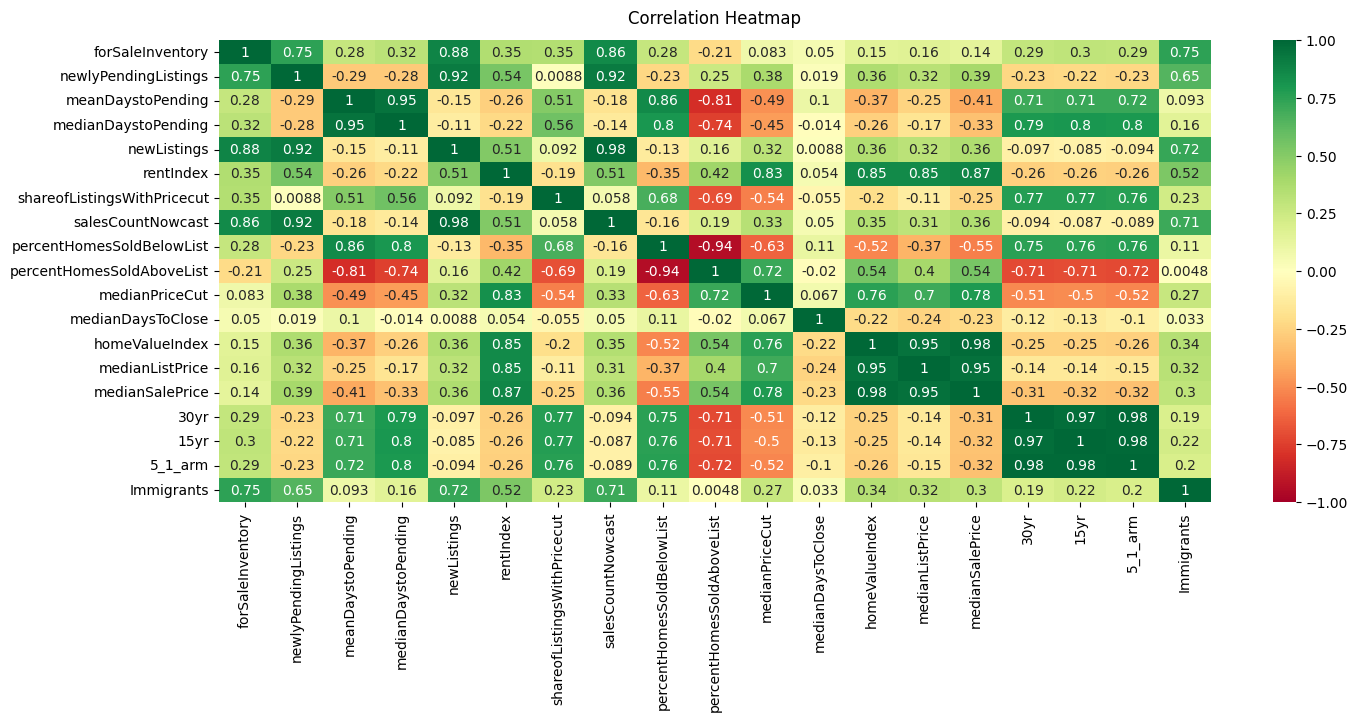

In [ ]:
# re-size of the heatmap.
plt.figure(figsize=(16, 6))
# set correlation values on heatmap from -1 to 1, and display correlation coeff on the heatmap.
heatmap = sns.heatmap(merged_Immigrant_df.corr(method='spearman', numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
# set Heatmap title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

##### ***Analysis:***

The immigration data provides yearly information at the state level. To calculate the correlation coefficient between the yearly immigrant counts and Zillow datasets, it is essential to aggregate all the Zillow data to a yearly and state-level basis. Upon analyzing the heatmap, it reveals a robust positive relationship between immigrant counts and various factors such as sale inventory, new listings, newly pending listings, and sales count nowcast. This indicates that an increase in the number of immigrants corresponds to a more active real estate market. Moreover, immigrants also have a positive impact on the rental market, as evidenced by a correlation coefficient of 0.52.

In [ ]:
# Note: The correlation matrix is created using merged_Immigrant_df, which is a dataframe that also includes the immigration data set and is aggreagated on a YEARLY level

select = widgets.Dropdown(options = merged_Immigrant_df["StateName"].unique(), description = 'Select State Correlation Matrix:')

def heatmap(state):
    filtered_df = merged_Immigrant_df[merged_Immigrant_df['StateName'] == state]
    corr = filtered_df.corr(method='pearson', numeric_only=True)
    plt.figure(figsize=(20, 8))
    corr_heatmap = sns.heatmap(corr, annot = True)
    plt.title(f"Correlation Heatmap for {state}")
    plt.show()

widgets.interact(heatmap, state = select)

interactive(children=(Dropdown(description='Select State Correlation Matrix:', options=('AL', 'AR', 'AZ', 'CA'…

<function __main__.heatmap(state)>

If you look at the last row, it shows the correlations of the 'Immigrants' (the number of immigrants to the state) and all the various variables in the real estate market.

Next, a bar graph is made to show the correlations between Immigrants (immigrants) and all other real estate market variables for all states, including the US country as a whole.

Generally, we can see that Immigrants has a strong positive correlation with:
- forSaleInventory
- meanDaystoPending
- medianDaystoPending
- shareofListingswithPricecut
- percentHomesSoldBelowList
- all mortagage rates

Observations:
- The higher the number of immigrants, the more demand for housing increases. We can see there are more available and new listings.
- Additionally, the higher the number of immigrants, the more likely houses will be sold below listing price and generally with a price cut.
- When the number of immigrants is higher, it also generally took longer for homes to change to pending status on Zillow after first being shown as for sale.
- Mortgage rates increases along with the demand.

Generally, we can see that Immigrants has a strong negative correlation with:
- medianListPrice
- newlyPendingListings
- Rent index (smoothedZORI)
- salesCountNowcast
- percentHomesSoldAboveList
- medianPriceCut
- medianDaysToClose
- homeValueIndex


In [ ]:
select2 = widgets.Dropdown(options = merged_Immigrant_df["StateName"].unique(), description = 'Select State:')

def correlation_bar(state):
    filtered_df = merged_Immigrant_df[merged_Immigrant_df['StateName'] == state]
    corr = filtered_df.corr(method='pearson', numeric_only=True)['Immigrants'].to_frame().T
    corr_sorted = corr.sort_values(by='Immigrants', ascending=False)

    plt.figure(figsize=(20, 8))

    cmap = ['red' if val >= 0 else 'blue' for val in corr_sorted.values.flatten()]
    corr_bar = sns.barplot(data = corr_sorted, orient = 'h', palette = cmap)
    plt.xlabel('Correlation')
    plt.ylabel('Variables')
    plt.title(f"Immigration Correlation Bar Graph for {state}")
    plt.show()

widgets.interact(correlation_bar, state = select2)

interactive(children=(Dropdown(description='Select State:', options=('AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL',…

<function __main__.correlation_bar(state)>

### *Can Mortgage rate be used to predict home prices?*

From the graphs, we can see that the 30-year fixed mortgage rate and 15-year fixed mortgage rate has an overall positive spearman correlation, meaning these mortgage rates have a positive relationship with home prices. As these mortgage rates increase, home prices increase as well.

However, with 5/1 hybrid amortizing adjustable mortgage rate having an overall negative spearman correlation, meaning this rate have a negative relationship with home prices. As this mortgage rates increase, home prices tend to decrease.

In [ ]:
rates = ['30yr', '15yr', '5_1_arm']

def correlation_line(df, x, y, color, method):
    correlations = []
    for state in df['StateName'].unique():
        state_data = df[df['StateName'] == state]
        corr_matrix = state_data[[x, y]].corr(method=method)
        correlation = corr_matrix.loc[x, y]
        correlations.append((state, correlation))
    states = [state[0] for state in correlations]
    correlation_values = [state[1] for state in correlations]

    # Plot the line graph
    fig = go.Scatter(x = states, y = correlation_values, mode = 'lines+markers', line = dict(color=color),name=f'{y}')

    return fig

def combine_lines(df, rates, x, y, z, method):
    for rate in rates:
        lines = []
        a = correlation_line(df, rate, x, "red", method)
        b = correlation_line(df, rate, y, "blue", method)
        c = correlation_line(df, rate, z, "green", method)

        lines.extend([a,b,c])
        fig = go.Figure(lines)
        fig.update_layout(xaxis_title='States',yaxis_title=f'Correlation ({rate})',title=f'Correlation for {rate} vs {x}, {y}, {z}',showlegend=True)

        fig.show()

In [ ]:
combine_lines(df_merged, rates, 'medianListPrice', 'medianSalePrice', 'homeValueIndex', 'spearman')

##### ***Analysis:***

- https://www.rocketmortgage.com/learn/interest-rate-vs-home-price
- There's typically an inverse relationship between interest rates and house prices.When the Federal Reserve raises interest rates, home buyers can’t afford expensive houses, so the prices will start to drop. When mortgage rates are low, buyers have more money to spend, so home prices will start to rise.
- Mortgage rates play an important role in predicting home prices due to their impact and influence on the affordability of homes and the demand for housing.
When mortgage rates are lower, potential buyers find it more affordable to purchase a home. This leads to increased demand and higher home prices.
- The reverse is also true. Higher mortgage rates makes it more expensive for buyers to borrow which decreases demand and home prices.
